In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display
import numpy.ma as ma
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import warnings 
import sksurv
from sklearn.preprocessing import MinMaxScaler
from lifelines import CoxPHFitter
from lifelines import WeibullAFTFitter
from lifelines import LogLogisticAFTFitter
from lifelines import LogNormalAFTFitter
from lifelines import AalenAdditiveFitter
from scipy.stats import spearmanr
from lifelines.utils import k_fold_cross_validation
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from metrics import cindex

In [124]:
def concat2(dfs, join='inner'):
    return pd.concat(dfs, axis=1, join=join)


def get_significant_features(X, y, source_dataset=None, multivariate=False):
    significant_features = [] 

    if multivariate:
        cph = CoxPHFitter()
        data = concat2([X, source_dataset, y])  
        cph.fit(data, duration_col='SurvivalTime', event_col='Event')

        cph.print_summary()
        
    else:
        for column in X:
            cph = CoxPHFitter()
            data = concat2([X[column], source_dataset, y])   
            cph.fit(data, duration_col='SurvivalTime', event_col='Event')

            if cph.summary.p[0] <= 0.005:
                significant_features.append([column, cph.summary.coef[0], cph.summary.z[0], '< 0.005'])
    
    df = pd.DataFrame(significant_features, columns = ['feature', 'coef', 'z', 'p'])
    
    return df

def get_features(radiomics):
    shape_cols = [col for col in radiomics.columns if 'shape' in col]
    firstorder_cols = [col for col in radiomics.columns if 'firstorder' in col]
    glcm_cols = [col for col in radiomics.columns if 'glcm' in col]
    glrlm_cols = [col for col in radiomics.columns if 'glrlm' in col]
    
    return shape_cols, firstorder_cols, glcm_cols, glrlm_cols

def cross_validate(X, y):
    all_scores = []
    
    cph = CoxPHFitter()

    for i in range(50):
        scores = k_fold_cross_validation(cph, concat2([X, y]), 'SurvivalTime', event_col='Event', k=3)
        all_scores.append(scores)

    print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(all_scores), np.std(all_scores) * 2))
    print("Max: %0.2f" % np.max(all_scores))
    print("Min: %0.2f" % np.min(all_scores))

# Read data

In [3]:
train_clinical = pd.read_csv('train/features/clinical_data.csv')
train_clinical = train_clinical.fillna({'Histology':'nos'})
train_clinical.loc[train_clinical['Histology'].str.startswith('Adeno'), 'Histology'] = 'adenocarcinoma'
train_clinical.loc[train_clinical['Histology'].str.startswith('Squamous'), 'Histology'] = 'squamous cell carcinoma'
train_clinical.loc[train_clinical['Histology'].str.startswith('NSCLC'), 'Histology'] = 'nos'
train_clinical = train_clinical.set_index('PatientID')
train_clinical.sort_index(inplace=True)
le = LabelEncoder()
train_clinical['SourceDataset'] = le.fit_transform(train_clinical['SourceDataset'])
le = LabelEncoder()
train_clinical['Histology'] = le.fit_transform(train_clinical['Histology'])

train_radiomics = pd.read_csv('train/features/radiomics.csv', index_col=0, header=1)[1:]
scaler = MinMaxScaler()
train_radiomics = pd.DataFrame(columns=train_radiomics.columns, data=scaler.fit_transform(train_radiomics)).set_index(train_radiomics.index.astype(int))
train_radiomics.sort_index(inplace=True)

train_y = pd.read_csv('output.csv', index_col=0)
train_y.sort_index(inplace=True)


### Separate data from Dataset1 and Dataset2

In [4]:
train_radiomics_d1 = train_radiomics.loc[train_clinical['SourceDataset'] == 0]
train_clinical_d1 = train_clinical.loc[train_clinical['SourceDataset'] == 0][['Tstage','Nstage', 'age']]
train_clinical_d1 = train_clinical_d1.dropna()

train_radiomics_d2 = train_radiomics.loc[train_clinical['SourceDataset'] == 1]
train_clinical_d2 = train_clinical.loc[train_clinical['SourceDataset'] == 1][['Tstage','Nstage','age']]

### Get most significant features based on Cox regression (p<0.005)

The goal here was to perform an univariate analysis on each of the radiomics feature with the Cox model, in order to select the most significant features, based on their p-values, Wald test and coef.

In [5]:
shape_cols, firstorder_cols, glcm_cols, glrlm_cols = get_features(train_radiomics)

In [6]:
print('Most significant radiomics in D1')
print(get_significant_features(train_radiomics_d1, train_y))

print('\n\nMost significant radiomics in D2')
print(get_significant_features(train_radiomics_d2, train_y))

Most significant radiomics in D1
                                 feature      coef         z        p
0       original_shape_Maximum3DDiameter  1.613142  3.409838  < 0.005
1             original_shape_SurfaceArea  1.824395  3.524926  < 0.005
2             original_shape_VoxelVolume  1.854650  3.937962  < 0.005
3            original_firstorder_Maximum  1.640280  3.022859  < 0.005
4              original_firstorder_Range  1.644968  2.930629  < 0.005
5  original_glrlm_GrayLevelNonUniformity  2.066596  3.440194  < 0.005
6  original_glrlm_RunLengthNonUniformity  3.197678  3.763747  < 0.005


Most significant radiomics in D2
Empty DataFrame
Columns: [feature, coef, z, p]
Index: []


As we can see, it seems there is a disparity regarding feature significance between Dataset 1 and Dataset 2, since there are no significant radiomics for Dataset2.  
This seems strange to me, I will now try to select the best features by adding the `SourceDataset` as an independant variable in the Cox Regression.   
This way, I hope to find features that are significant for the whole training set.

In [7]:
source_dataset = train_clinical['SourceDataset']

significant_shape = get_significant_features(train_radiomics[shape_cols], train_y, source_dataset)
significant_firstorder = get_significant_features(train_radiomics[firstorder_cols],train_y, source_dataset)
significant_glcm = get_significant_features(train_radiomics[glcm_cols], train_y, source_dataset)
significant_glrlm = get_significant_features(train_radiomics[glrlm_cols], train_y, source_dataset)

In [8]:
most_significants = significant_shape.append([significant_firstorder, significant_glcm, significant_glrlm])

In [12]:
most_significants

,feature,coef,z,p
0,original_shape_Maximum3DDiameter,1.688411,3.913716,< 0.005
1,original_shape_SurfaceArea,1.594183,3.817638,< 0.005
2,original_shape_VoxelVolume,1.689890,4.062962,< 0.005
0,original_firstorder_Maximum,1.838941,3.752455,< 0.005
1,original_firstorder_Mean,1.496197,3.115316,< 0.005
2,original_firstorder_Median,1.548006,3.078729,< 0.005
3,original_firstorder_Range,1.873498,3.732152,< 0.005
0,original_glcm_Autocorrelation,1.412440,3.674538,< 0.005
1,original_glcm_ClusterProminence,1.851372,2.963890,< 0.005
2,original_glcm_Id,1.145406,3.083568,< 0.005


### Spearman correlation of features

In [13]:
def show_spearman_corr(df):
    rho, pval = spearmanr(df)

    corr = pd.DataFrame(rho)
    corr.columns = df.columns
    corr.index = df.columns

    plt.figure(figsize =(len(df.columns),len(df.columns)))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn")
    
    
def spearman_groups_by_mean(normalized_df, threshold=0.9, df_name=None):
    
    """
    This function averages features that are highly "Spearman-correlated" (above threshold).
    It takes care of inverting negatively correlated features before averaging, and does not re-use features
    that were previously averaged.
    """

    correlated_cols = dict()

    for column_to_test in normalized_df.columns:
        column_to_test_corrs = []
        key_already_in = None
        for column in normalized_df.columns:

            if correlated_cols.get(column) != None and column_to_test in correlated_cols.get(column):
                key_already_in = column
                continue

            if key_already_in != None and column in correlated_cols[key_already_in]:
                continue
                
            spearman_corr = spearmanr(normalized_df[column_to_test], normalized_df[column]).correlation
            
            if np.abs(spearman_corr) >= threshold:
                column_to_test_corrs.append(column)

        if key_already_in == None:        
            correlated_cols[column_to_test] = column_to_test_corrs

    
    normalized_df_grouped = pd.DataFrame()
    
    for i, (key, columns) in enumerate(correlated_cols.items()):
        name = 'group' + str(i) if df_name is None else df_name + str(i)

        if len(columns) == 1:
            normalized_df_grouped[name] = normalized_df[columns[0]]

        else:
            sum_ = 0
            for column in columns:
                if  spearmanr(normalized_df[columns[0]], normalized_df[column]).correlation < 0:
                    sum_ += 1/(normalized_df[column] + 0.0001)
                else:
                    sum_ += normalized_df[column]

                if np.isinf(sum_).sum() > 0:
                    print(columns[0], column)
                    
            mean = sum_ / len(columns)
            normalized_df_grouped[name] = mean
        
    return normalized_df_grouped, correlated_cols

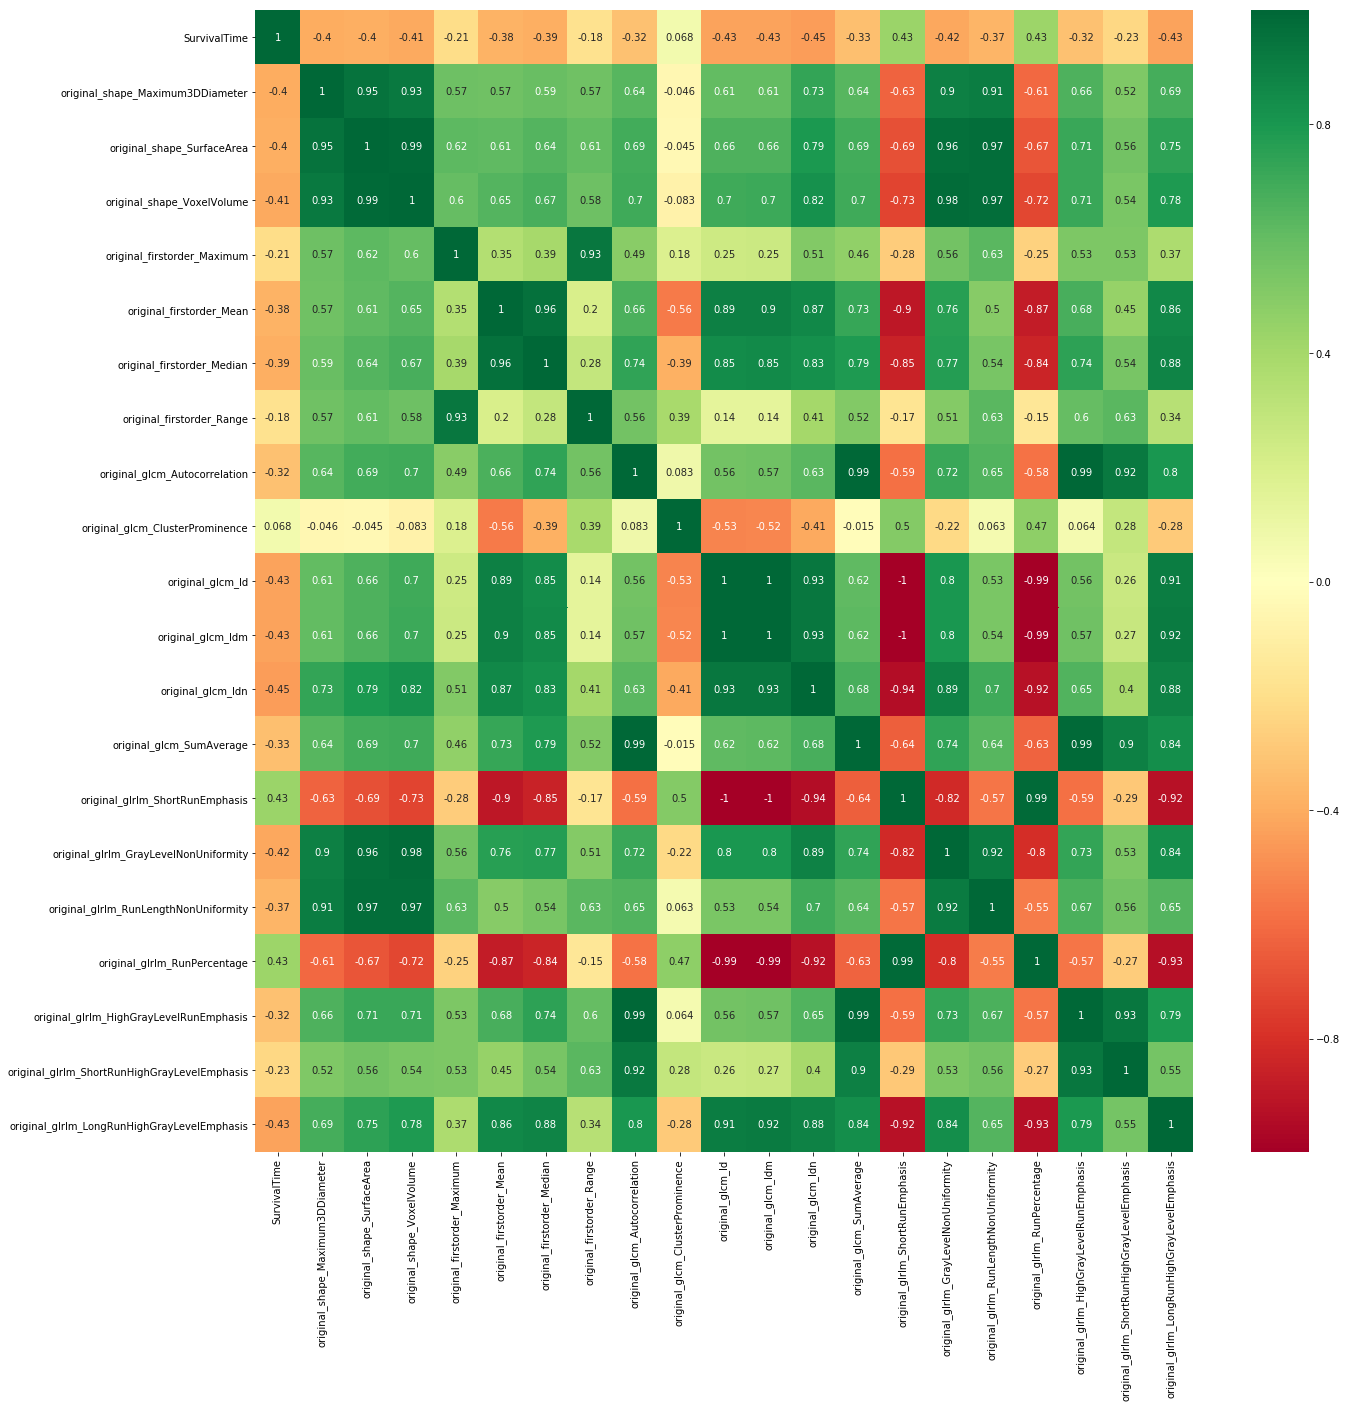

In [14]:
df_most_significants = train_radiomics[most_significants['feature']]

show_spearman_corr(concat2([train_y['SurvivalTime'], df_most_significants]))

### Grouping features by type (shape, firstorder, glcm, glrlm)

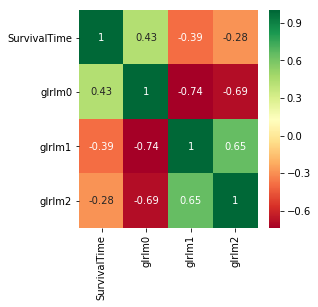

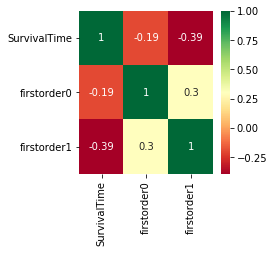

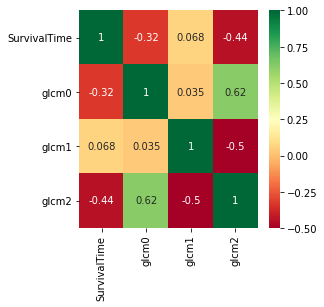

In [15]:
glrlm_grouped, cols = spearman_groups_by_mean(train_radiomics[significant_glrlm['feature']], 0.9, 'glrlm')
shape_grouped, cols = spearman_groups_by_mean(train_radiomics[significant_shape['feature']], 0.9, 'shape')
firstorder_grouped, cols = spearman_groups_by_mean(train_radiomics[significant_firstorder['feature']], 0.9, 'firstorder')
glcm_grouped, cols = spearman_groups_by_mean(train_radiomics[significant_glcm['feature']], 0.9, 'glcm')

show_spearman_corr(concat2([train_y['SurvivalTime'] ,glrlm_grouped]))
#show_spearman_corr(concat2([train_y['SurvivalTime'] ,shape_grouped]))
show_spearman_corr(concat2([train_y['SurvivalTime'] ,firstorder_grouped]))
show_spearman_corr(concat2([train_y['SurvivalTime'] ,glcm_grouped]))

In [153]:
grouped_by_type = concat2([shape_grouped, firstorder_grouped, glcm_grouped, glrlm_grouped])
spearman_by_type, cols = spearman_groups_by_mean(grouped_by_type, 0.9)

X_by_type = concat2([spearman_by_type, train_clinical[['SourceDataset', 'Nstage', 'age']]])
X_by_type = X_by_type.fillna(np.mean(train_clinical[['age']]))

In [145]:
cph = CoxPHFitter()
cph.fit(concat2([X_by_type, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

In [146]:
all_scores = []

for i in range(50):
    scores = k_fold_cross_validation(cph, concat2([X_by_type, train_y]), 'SurvivalTime', event_col='Event', k=3)
    all_scores.append(scores)

all_scores = np.array(all_scores).flatten()
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(all_scores), np.std(all_scores) * 2))
print("Max: %0.2f" % np.max(all_scores))
print("Min: %0.2f" % np.min(all_scores))

Accuracy: 0.70 (+/- 0.06)
Max: 0.77
Min: 0.60


### Grouping features without respect to their type

In [16]:
most_significants = significant_shape.append([significant_firstorder, significant_glcm])
df_most_significants = train_radiomics[most_significants['feature']]

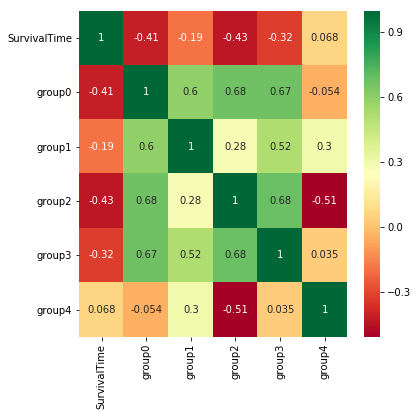

In [20]:
grouped_by_mean, cols = spearman_groups_by_mean(df_most_significants, 0.8)
show_spearman_corr(concat2([train_y['SurvivalTime'] ,grouped_by_mean]))

In [131]:
X_spearman = concat2([grouped_by_mean, train_clinical[['SourceDataset', 'Nstage', 'age']]])
X_spearman = X_spearman.fillna(np.mean(train_clinical['age']))

cph = CoxPHFitter()
cph.fit(concat2([X_spearman, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

In [132]:
cross_validate(X_spearman, train_y)

Accuracy: 0.70 (+/- 0.06)
Max: 0.76
Min: 0.62


Let's try to keep only the significant groups (group2 and group4) 

In [128]:
X_spearman = concat2([grouped_by_mean[['group2', 'group4']], train_clinical[['SourceDataset', 'Nstage', 'age']]])
X_spearman = X_spearman.fillna(np.mean(train_clinical['age']))

cph = CoxPHFitter()
cph.fit(concat2([X_spearman, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

In [129]:
cross_validate(X_spearman, train_y)

Accuracy: 0.71 (+/- 0.06)
Max: 0.77
Min: 0.63


We can also try to use the features inside the groups, and add the most significant glrlm feature, that was not present in our original groups

In [135]:
columns = ['original_firstorder_Mean',
           'original_glrlm_GrayLevelNonUniformity',
  'original_glcm_ClusterProminence']

X_spearman = concat2([train_radiomics[columns], train_clinical[['SourceDataset', 'Nstage', 'age']]])
X_spearman = X_spearman.fillna(np.mean(train_clinical['age']))

cph = CoxPHFitter()
cph.fit(concat2([X_spearman, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

We get quite significant features and a higher log-likelihood ratio test.  
Apparently, *"The Likelihood ratio test has better behavior for small sample sizes, so it is generally preferred."*  
We can assume that these features will give us good results.

In [136]:
cross_validate(X_spearman, train_y)

Accuracy: 0.71 (+/- 0.06)
Max: 0.79
Min: 0.61


We achieve a decent result that is better than everything else we've tried.  
C-index of 0.71 with a variance of 0.06/0.005 seems acceptable. 
We can see that 


## PCA

In [110]:
pca = PCA()

grouped_by_pca = pca.fit_transform(df_most_significants)
grouped_by_pca = pd.DataFrame(grouped_by_pca).set_index(df_most_significants.index)
pca.explained_variance_ratio_

array([6.87150030e-01, 1.23285575e-01, 8.93582663e-02, 3.53755369e-02,
       2.63775481e-02, 1.44299492e-02, 1.24028994e-02, 7.09768898e-03,
       2.39213730e-03, 1.78670225e-03, 3.06056294e-04, 2.92477659e-05,
       8.36271831e-06])

In [120]:
X_pca = pd.concat([grouped_by_pca[[0, 1]], train_clinical[['SourceDataset', 'Nstage', 'age']]], axis=1)
X_pca = X_pca.fillna(np.mean(train_clinical['age']))

In [121]:
cph = CoxPHFitter()
cph.fit(concat2([X_pca, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()

In [125]:
cross_validate(X_pca, train_y)

Accuracy: 0.69 (+/- 0.06)
Max: 0.77
Min: 0.62


### Lifelines models

In [1572]:
test_clinical = pd.read_csv('test/features/clinical_data.csv')
test_clinical = test_clinical.set_index('PatientID')
test_clinical.sort_index(inplace=True)
le = LabelEncoder()
test_clinical['SourceDataset'] = le.fit_transform(test_clinical['SourceDataset'])


train_radiomics2 = pd.read_csv('train/features/radiomics.csv', index_col=0, header=1)[1:]

test_radiomics = pd.read_csv('test/features/radiomics.csv', index_col=0, header=1)[1:]
test_radiomics.index = test_radiomics.index.astype(int)
test_radiomics.sort_index(inplace=True)

all_radiomics = test_radiomics.append(train_radiomics2)

scaler = MinMaxScaler()
all_radiomics = pd.DataFrame(columns=all_radiomics.columns, data=scaler.fit_transform(all_radiomics)).set_index(all_radiomics.index)

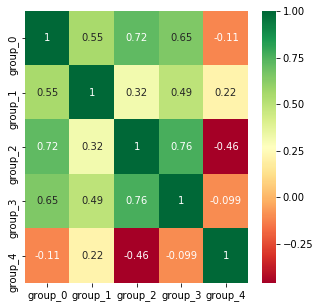

In [1573]:
df_test_most_significants = all_radiomics.loc[test_radiomics.index][most_significants['feature']]
grouped_by_mean_test, cols_test = spearman_groups_by_mean(df_test_most_significants, 0.8)
show_spearman_corr(grouped_by_mean_test)

In [1574]:
final_X = concat2([grouped_by_mean_test[['group_2', 'group_4']], test_clinical[['SourceDataset', 'Nstage', 'age']]])

In [1621]:
final_X = final_X.fillna(train_clinical.append(test_clinical)['age'].mean())

In [1622]:
final_X.isna().sum()

group_2          0
group_4          0
SourceDataset    0
Nstage           0
age              0
dtype: int64

In [1623]:
final_preds = pd.DataFrame({"SurvivalTime": cph.predict_expectation(final_X)[0], "Event": np.nan})

In [1624]:
fifth_submit = pd.read_csv("fifth_submit.csv").set_index("Unnamed: 0")

concat2([final_preds, fifth_submit])

,SurvivalTime,Event,SurvivalTime,Event
0,2449.748881,NaN,2591.655479,NaN
1,692.024074,NaN,778.851240,NaN
6,974.238226,NaN,911.522880,NaN
9,3053.683077,NaN,2809.492603,NaN
10,462.889547,NaN,666.757884,NaN
12,1552.077603,NaN,1554.383982,NaN
13,1667.881253,NaN,1009.008298,NaN
19,1869.136789,NaN,1508.397634,NaN
27,1158.544550,NaN,931.257490,NaN
28,2384.917702,NaN,2427.527655,NaN


In [1625]:
final_preds.to_csv("sixth_submit.csv")

### Sksurv models

In [178]:
def cindex_score(estimator, X, y):
    preds = pd.DataFrame({'SurvivalTime':pd.DataFrame(estimator.predict(X)), 'Event':np.nan}).set_index(X.index)[0]
    return cindex(pd.DataFrame({'SurvivalTime': y['SurvivalTime'], 'Event': y['Event']}), preds).set_index(X.index)[0]

In [179]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import IPCRidge

In [222]:
model = CoxPHSurvivalAnalysis()

sk_train_y = sksurv.util.Surv.from_dataframe('Event', 'SurvivalTime', train_y.loc[test_spearman.index])

from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3)

scores = cross_val_score(model, X_spearman, sk_train_y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.71746776 0.70657035 0.69538876 0.70748547 0.71280277]
Accuracy: 0.71 (+/- 0.01)


In [223]:
model.fit(test_spearman, sk_train_y)
preds = model.predict(test_spearman)

In [224]:
preds = pd.DataFrame({'SurvivalTime':pd.DataFrame(model.predict(test_spearman)).set_index(test_spearman.index)[0], 'Event':np.nan})
#preds.replace([np.inf, -np.inf], 3000)
cindex(train_y, preds)

NameError: name 'pd' is not defined

In [230]:
# train_X = concat(train_radiomics_d2[most_significants['feature']], train_clinical_d1)

cph = CoxPHFitter()
cph.fit(concat2([grouped_by_mean, train_y]), duration_col='SurvivalTime', event_col='Event')
cph.print_summary()